My project will be connected with analyzing word2vec models built on datasets with different english songs and two very different books, one is adventure and the second is a detective story. We will look at word embeddings distribution built by word2vec, and answer the final question - Is it better to train word2vec on books or on songs. We will also create a database with songs and their authors. (additional part of the work, working with SQL databases)

In [1]:
import random  #here we set the randomisation, it should be fixed for better working of the w2v models
import numpy as np
seed = 100
random.seed(seed)
np.random.seed(seed)

In [2]:
#here we import modules
import pandas
import torch
import numpy
from pymystem3 import Mystem
import nltk

In [3]:
#here we import modules (punctuational and removing parasite-words)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maximdoronkin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maximdoronkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#here we import modules
import re
import gensim
import logging
import nltk.data
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from pymystem3 import Mystem

import warnings
warnings.filterwarnings('ignore')

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) #setting logging

The function below makes important work, it preprocesses the given text, no matter it will be a poem or a book.

In [6]:
m = Mystem()
stop_words = set(stopwords.words('english'))
def preprocess_text(file):
    with open(file, 'r', encoding='utf8', errors='ignore') as f:
        text = f.read()

    new_text = sent_tokenize(text)
    new_lines = []

    for sentence in tqdm(new_text):
        words = nltk.word_tokenize(sentence)
        words = [word for word in words if not word in stop_words]
        new_words= [word for word in words if word.isalnum()]   
        new_lines.append(new_words)
    return new_lines

Now we look at the files path and here we will start the first part of the research: working with songs

In [7]:
file = '0'
archive_of_song_lyrics = 'Documents/archive/'+file

In [8]:
import sqlite3 #SQL module

# connecting to DataBase
conn = sqlite3.connect('SONGS.db') #creating SQL database with SONGS
# creating coursor object
c = conn.cursor()

In [9]:
c.execute("CREATE TABLE IF NOT EXISTS _SONGS_(author,	songs)")  #creating a table with two columns, with author and his song

In [10]:
import os

song_corpus = []
preprocessed_words = []
for file in os.listdir("archieve"):
    lines = preprocess_text('archieve/'+file)
    preprocessed_words.append(lines)
    for w in lines:
        song_corpus.append(w)

100%|██████████| 361/361 [00:00<00:00, 2898.29it/s]


In [11]:
texts = []
for file in os.listdir("archieve"):
    text_ = 'archieve/'+file
    text__ = ''
    with open(text_, 'r', encoding='utf8', errors='ignore') as t:
        text = t.read()
        lines = [s.strip() for s in text.split('\n') if s]
        text_i = ''
        for i in lines:
            text_i+=' '
            text_i+=i
        text__+=text_i
    texts.append(text_i)

In [12]:
for file in os.listdir("archieve"):
    i = 0
    c.execute("INSERT INTO _SONGS_ VALUES (?, ?)", (file[:-4], texts[i])) 
    i += 1

We finished creating a database with a table with 2 columns, we won't come back to it. It may help others for future research

In [13]:
print(len(song_corpus))  #whole number of words in the corpus, that consists of preprocessed words from songs

18627


Now we create and train WORD2VEC model

In [14]:
model_poems = Word2Vec(size = 300, window=2, min_count=1)    
model_poems.build_vocab(song_corpus, progress_per=10000)
model_poems.train(song_corpus, total_examples=model_poems.corpus_count, epochs=30, report_delay=1)

2020-11-21 21:52:31,507 : INFO : collecting all words and their counts
2020-11-21 21:52:31,510 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-21 21:52:31,596 : INFO : PROGRESS: at sentence #10000, processed 429794 words, keeping 25654 word types
2020-11-21 21:52:31,664 : INFO : collected 34685 word types from a corpus of 851039 raw words and 18627 sentences
2020-11-21 21:52:31,665 : INFO : Loading a fresh vocabulary
2020-11-21 21:52:31,794 : INFO : effective_min_count=1 retains 34685 unique words (100% of original 34685, drops 0)
2020-11-21 21:52:31,795 : INFO : effective_min_count=1 leaves 851039 word corpus (100% of original 851039, drops 0)
2020-11-21 21:52:31,887 : INFO : deleting the raw counts dictionary of 34685 items
2020-11-21 21:52:31,888 : INFO : sample=0.001 downsamples 43 most-common words
2020-11-21 21:52:31,888 : INFO : downsampling leaves estimated 740745 word corpus (87.0% of prior 851039)
2020-11-21 21:52:31,960 : INFO : estimated r

(19717422, 25531170)

In [15]:
model_poems.wv.similarity("woman", "girl")   #as we see our model is not very good

0.36511838

In [16]:
model_poems.wv.similarity("chick", "girl") #better with more modern word which we see in songs

0.38084882

In [17]:
def show_first_10_most_semantically_similar_words(model):
    for word in ['girl', 'good', 'wall', 'fire', 'like']:
        # is the word present in the model?
        if word in model:
            print(word)
            # looking at the first 10 numbers from the embedding 
            print(model[word][:10])
            # getting 10 neighbours
            for i in model.most_similar(positive=[word], topn=10):
                # word + cosine similarity
                print(i[0], i[1])
            print('\n')
        else:
            # Oops!
            print('Oops, the word "%s" is not in the model!' % word)
show_first_10_most_semantically_similar_words(model_poems)

2020-11-21 21:54:21,450 : INFO : precomputing L2-norms of word weight vectors


girl
[ 1.4833032  -0.43672687  0.36073458  0.8769017   0.7962256   1.1683064
  0.40781942 -0.9647298  -1.6974324   0.06843131]
nasty 0.43088120222091675
boy 0.3937450051307678
chick 0.38084888458251953
woman 0.3651183843612671
settle 0.36205029487609863
problem 0.3555505871772766
bit 0.3442194163799286
guy 0.3416540026664734
baby 0.3341555595397949
coming 0.32758647203445435


good
[ 0.20487852  0.25247148  0.4505532   0.94253993  1.5934209  -0.42719418
  0.14325285 -0.4260572  -0.6081816   0.441017  ]
prosperous 0.3593844473361969
real 0.3555196225643158
feelin 0.3531378507614136
pain 0.35285302996635437
funny 0.34427952766418457
fucked 0.33773577213287354
na 0.33773013949394226
happens 0.33739328384399414
important 0.33332163095474243
sexy 0.3330508768558502


wall
[-0.42782193 -0.25521326  0.02452621  0.07656661  0.08341298 -0.36888283
  0.2750464   0.42607766  0.49432415 -0.18387076]
punctuate 0.47919920086860657
puking 0.47794124484062195
Pastry 0.4402727484703064
curtain 0.424115

We see that model based on song corpus does not clearly predicts the most semantically similar word in our real life. Ehy is it so? It is so because songs are often created on the topic of love and therefore the word "girl" will be more assosiated with the "chick" than with "woman" because it depends on songs speciality, people use not simple phrases, and it depends on the historical period as well, though song text corpus is built on nowadays singers.

Now let's go to the second part of the research, looking at book texts by Agatha Christie (detective story - "Dearh on the Nile") and Jule Verne (fantastic adventure - "20000 leages under the sea")

In [18]:
Agatha_Christies_texts_corpus = ['Death-On-The-Nile.txt']
Jules_Verne_texts_corpus = ['20000.rtf']

Now let's train Word2Vec models on the texts

In [19]:
for text in Agatha_Christies_texts_corpus:
    new_lines_agatha = preprocess_text(text)
    model_agatha = Word2Vec(size = 300, window=1, min_count=1)   
    model_agatha.build_vocab(new_lines_agatha, progress_per=10000)
    model_agatha.train(new_lines_agatha, total_examples=model_agatha.corpus_count, epochs=30, report_delay=1)

100%|██████████| 7448/7448 [00:01<00:00, 5776.75it/s]
2020-11-21 21:54:35,073 : INFO : collecting all words and their counts
2020-11-21 21:54:35,073 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-21 21:54:35,092 : INFO : collected 6683 word types from a corpus of 42271 raw words and 7448 sentences
2020-11-21 21:54:35,093 : INFO : Loading a fresh vocabulary
2020-11-21 21:54:35,113 : INFO : effective_min_count=1 retains 6683 unique words (100% of original 6683, drops 0)
2020-11-21 21:54:35,113 : INFO : effective_min_count=1 leaves 42271 word corpus (100% of original 42271, drops 0)
2020-11-21 21:54:35,149 : INFO : deleting the raw counts dictionary of 6683 items
2020-11-21 21:54:35,150 : INFO : sample=0.001 downsamples 43 most-common words
2020-11-21 21:54:35,150 : INFO : downsampling leaves estimated 37022 word corpus (87.6% of prior 42271)
2020-11-21 21:54:35,174 : INFO : estimated required memory for 6683 words and 300 dimensions: 19380700 bytes
202

In [20]:
for text in Jules_Verne_texts_corpus:
    new_lines_jule = preprocess_text(text)
    model_jule = Word2Vec(size = 300, window=1, min_count=1)   
    model_jule.build_vocab(new_lines_jule, progress_per=10000)
    model_jule.train(new_lines_jule, total_examples=model_jule.corpus_count, epochs=30, report_delay=1)

100%|██████████| 2090/2090 [00:00<00:00, 6759.36it/s]
2020-11-21 21:55:10,855 : INFO : collecting all words and their counts
2020-11-21 21:55:10,855 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-21 21:55:10,861 : INFO : collected 5341 word types from a corpus of 19382 raw words and 2090 sentences
2020-11-21 21:55:10,863 : INFO : Loading a fresh vocabulary
2020-11-21 21:55:10,874 : INFO : effective_min_count=1 retains 5341 unique words (100% of original 5341, drops 0)
2020-11-21 21:55:10,875 : INFO : effective_min_count=1 leaves 19382 word corpus (100% of original 19382, drops 0)
2020-11-21 21:55:10,900 : INFO : deleting the raw counts dictionary of 5341 items
2020-11-21 21:55:10,900 : INFO : sample=0.001 downsamples 26 most-common words
2020-11-21 21:55:10,901 : INFO : downsampling leaves estimated 18164 word corpus (93.7% of prior 19382)
2020-11-21 21:55:10,914 : INFO : estimated required memory for 5341 words and 300 dimensions: 15488900 bytes
202

In [21]:
show_first_10_most_semantically_similar_words(model_agatha)

2020-11-21 21:55:17,718 : INFO : precomputing L2-norms of word weight vectors


girl
[-0.08929363 -0.1057674   0.08301657  0.15511873  0.31376404  0.132018
  0.11930279  0.15845223 -0.01605319 -0.3563892 ]
combined 0.9452272057533264
cautious 0.944582462310791
telephone 0.9360426664352417
expression 0.9359419345855713
Desert 0.9335581064224243
Barren 0.932586133480072
entire 0.9319137930870056
bon 0.9317128658294678
procession 0.9290114045143127
friendship 0.9287800788879395


good
[-0.2664436  -0.05100249  0.02369927  0.16345328  0.11989176  0.07008989
  0.09654446 -0.05386116  0.23673147 -0.3133386 ]
Clear 0.9426881670951843
far 0.9216550588607788
astounded 0.9181070327758789
deal 0.9160429239273071
marry 0.9148531556129456
things 0.9147371053695679
true 0.9119892120361328
comply 0.9119702577590942
Poppa 0.9106424450874329
believed 0.9104852676391602


wall
[-0.06040157 -0.03022976 -0.0030513   0.04328581  0.06474999  0.02463825
  0.0883616   0.07049754  0.03334976 -0.18047923]
chin 0.9978666305541992
desk 0.9978469610214233
annoy 0.9976807236671448
Man 0.997676

In [22]:
show_first_10_most_semantically_similar_words(model_jule)

2020-11-21 21:55:20,633 : INFO : precomputing L2-norms of word weight vectors


Oops, the word "girl" is not in the model!
good
[-0.08370189  0.05036613  0.16446309  0.18037257  0.07170582  0.07094422
  0.17560059 -0.20707674 -0.02616582 -0.12466414]
master 0.9997168779373169
word 0.9996523857116699
polypi 0.9996505379676819
They 0.9996490478515625
thought 0.9996458292007446
came 0.9996458292007446
believe 0.9996384382247925
perhaps 0.9996340274810791
get 0.9996339678764343
matter 0.9996330142021179


wall
[-0.00620152  0.00292002  0.0084945   0.00972216  0.00271368  0.00342126
  0.01013064 -0.01089505 -0.00247879 -0.00665411]
craft 0.9913418889045715
surpassed 0.9911935329437256
fires 0.9911089539527893
resist 0.9910727739334106
inquiries 0.9910221695899963
provided 0.9910192489624023
sides 0.990942120552063
torrent 0.9908256530761719
change 0.9908072352409363
millions 0.9907934665679932


fire
[-0.03219917  0.01942726  0.06752423  0.07032394  0.02725579  0.02736942
  0.07028387 -0.08241309 -0.00884843 -0.05120768]
much 0.9996996521949768
produced 0.9996899366378

And now we will plot the distributions of the word embeddings by two models and see, how they differ from each other

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
word_1 = [w for w in model_jule.wv.vocab]
X_1 = model_jule[word_1]
words = [w for w in model_agatha.wv.vocab]
X = model_agatha[words]

In [24]:
pca = PCA(n_components=2)
coords_1 = pca.fit_transform(X_1)
xes_1 = [coords_1[i][0] for i in range(len(coords_1))]
yes_1 = [coords_1[i][1] for i in range(len(coords_1))]
print(np.mean(xes_1))
print(np.mean(yes_1))
A = [np.mean(xes_1), np.mean(yes_1)]

4.5710657e-08
-2.6426473e-08


In [25]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
#print(coords)
xes = [coords[i][0] for i in range(len(coords))]
yes = [coords[i][1] for i in range(len(coords))]
#print(xes)
print(np.mean(xes))
print(np.mean(yes))
B = [np.mean(xes), np.mean(yes)]

-2.9225274e-07
3.4248366e-09


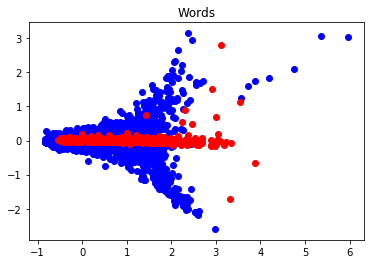

In [26]:
plt.scatter(coords[:, 0], coords[:, 1], color='blue')
plt.scatter(coords_1[:, 0], coords_1[:, 1], color='red')
#plt.scatter(coords_2[:, 0], coords_2[:, 1], color='yellow')
#plt.scatter(A[0], A[1], color = 'blue')
#plt.scatter(B[0], B[1], color= 'red')
plt.title('Words')

#for i, word in enumerate(words):
   # plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
#for i, word in enumerate(word_1):
   # plt.annotate(word, xy=(coords_1[i, 0], coords_1[i, 1]))
plt.show()

This final plot shows interesting thing, the book by Agatha Christie has more semantically different words, and the most important is the fact, that we see difference between the adventure book and the detective, so that we can teach the computer to detect the semantical style of the random book to identify its genre, so it can be made in the future researches...


Thats all for now.